In [2]:
from google.colab import files
uploaded = files.upload()

Saving 中债国债收益率曲线.xls to 中债国债收益率曲线.xls


I build 3 simple time-series model and take average on them. Both averaging and voting systems can also work fine when you use a mix of different machine learning algorithms. This is the averaging approach, and it’s widely used when you can’t reduce the estimate variance.
https://www.dummies.com/programming/averaging-different-predictors-machine-learning/

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import tensorflow as tf
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sklearn
import io
from google.colab import files
import random

In [4]:

### Data preprocessing: let the previous n yields as the input, the yeilds of the next day as the output
### Define a class, which splits the data into training set and test set, as well as the input and output
class DataProcessing:
    def __init__(self, file, train):
        self.file = file                                # read the data
        self.train = train                                  
        self.i = int(self.train * len(self.file))       # size of training set
        self.stock_train = self.file[0: self.i]         # get the training set
        self.stock_test = self.file[self.i:]            # get the test set
        self.input_train = []
        self.output_train = []
        self.input_test = []
        self.output_test = []

    def gen_train(self, seq_len):
        """
        Generates training data
        :param seq_len: length of window
        :return: X_train and Y_train
        """
        for i in range((len(self.stock_train)//seq_len)*seq_len-seq_len-1):
            x = np.array(self.stock_train.iloc[i:i+seq_len], np.float64)
            y = np.array(self.stock_train.iloc[i+seq_len], np.float64)
            self.input_train.append(x)
            self.output_train.append(y)
        self.X_train = np.array(self.input_train)
        self.Y_train = np.array(self.output_train)

    def gen_test(self, seq_len):
        """
        Generates test data
        :param seq_len: Length of window
        :return: X_test and Y_test
        """
        for i in range((len(self.stock_test)//seq_len)*seq_len-seq_len-1):
            x = np.array(self.stock_test.iloc[i:i+seq_len], np.float64)
            y = np.array(self.stock_test.iloc[i+seq_len], np.float64)
            self.input_test.append(x)
            self.output_test.append(y)
        self.X_test = np.array(self.input_test)
        self.Y_test = np.array(self.output_test)

In [5]:
### Read the data, drop NA
national_debt = pd.read_excel('中债国债收益率曲线.xls', parse_dates=True)   ### read the dataset
#national_debt = national_debt.iloc[1:(national_debt.shape[0]-2),1:]
national_debt = national_debt.iloc[1:len(national_debt)-2,:]
national_debt['指标名称'] = pd.to_datetime(national_debt['指标名称']).dt.date   ### change the index column to regular datetime format
national_debt.set_index('指标名称', inplace=True)
national_debt.index.names = ['Date']    ### change the index column's name to 'Date'
national_debt_s = national_debt.iloc[:,:national_debt.shape[1]-2].dropna()
national_debt_l = national_debt.iloc[:,national_debt.shape[1]-2:].dropna()

In [6]:
data = pd.DataFrame(national_debt_s.iloc[:,15])
data.columns = ['Yield of 10-year Treasury Bond']
data.head()

,Yield of 10-year Treasury Bond
Date,
2006-04-07,2.9291
2006-04-20,3
2006-04-21,3.048
2006-04-24,3.05
2006-04-29,3


In [8]:
p = 0.8
n = 100
e = 100
process_data = DataProcessing(data, p)
process_data.gen_test(n)
process_data.gen_train(n)
    
# reshape the training data and test data 
r_train = int((len(data)*p//n)*n - n - 1)
r_test = int((len(data)*(1-p)//n)*n - n - 1)
x_train = process_data.X_train.reshape((r_train,n,1))
y_train = process_data.Y_train.reshape((r_train,1,1))
x_test = process_data.X_test.reshape((r_test,n,1))
y_test = process_data.Y_test.reshape((r_test,1,1))

### Reformat the data to make it suitable for Tensorflow
x_train = K.cast_to_floatx(x_train)
y_train = K.cast_to_floatx(y_train)
x_test = K.cast_to_floatx(x_test)
y_test = K.cast_to_floatx(y_test)

**reshape data**

In [9]:
def process_y(X):
  l = []
  for item in X:
    l.append(item[0][0])
  return l

In [10]:
y_train = process_y(y_train)
y_test = process_y(y_test)

In [11]:
def process_inner(X):
  l= [] 
  for item in X:
    l.append(item[0])
  return l

def process_x(X):
  l=[]
  for item in X:
    l.append(process_inner(item))
  return l

In [12]:
x_train = process_x(x_train)
x_test = process_x(x_test)

**SVM model**

In [19]:
#train SVM model
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import time

In [20]:
start=time.time()
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
y_predict_svr = svr.fit(x_train, y_train).predict(x_test)
print('Training time cost {:.2f} s'.format(time.time()-start))

Training time cost 0.19 s


In [33]:
#prepare timestamps for the data
import pandas as pd
df = data.copy()
df['time'] = data.index
df['time'] = pd.to_datetime(df['time'])
df.head()

,Yield of 10-year Treasury Bond,time
Date,,
2006-04-07,2.9291,2006-04-07
2006-04-20,3,2006-04-20
2006-04-21,3.048,2006-04-21
2006-04-24,3.05,2006-04-24
2006-04-29,3,2006-04-29


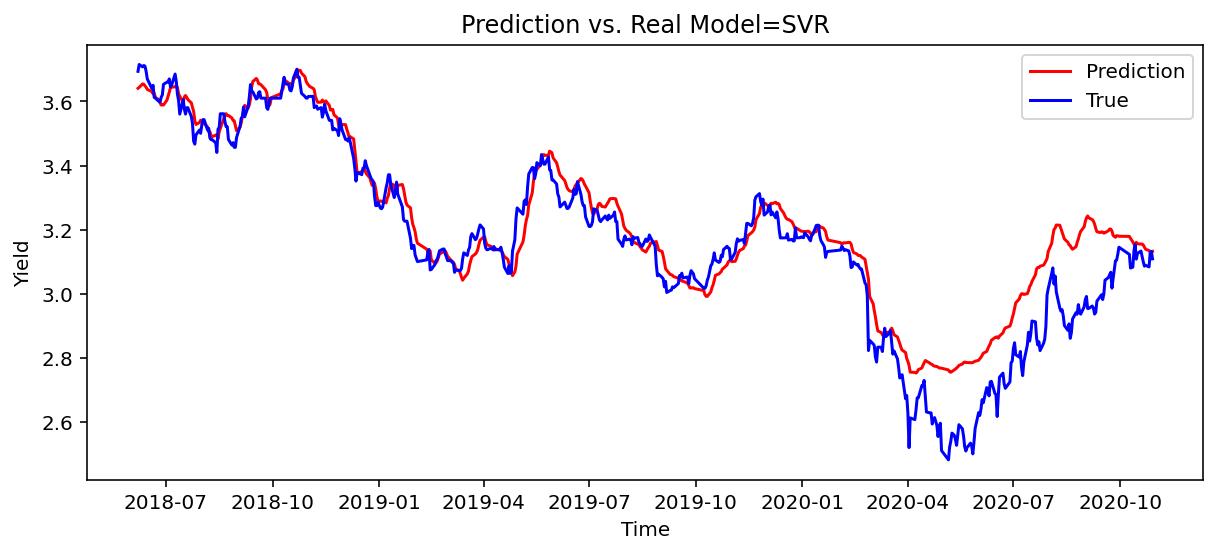

In [34]:
date = df['time'][2986:df.shape[0]]
plt.figure(figsize=(10,4))
plt.plot(date, y_predict_svr, color='red', label='Prediction')
plt.plot(date, y_test, color='blue', label="True")
plt.title('Prediction vs. Real Model=SVR')
plt.xlabel('Time')
plt.ylabel('Yield')
plt.legend(loc="upper right");

In [35]:
from scipy import stats
stats.ttest_ind(y_predict_svr, y_test)

Ttest_indResult(statistic=3.320672500193518, pvalue=0.0009251089836317673)

In [36]:
def MSE(a,b):
  l=[]
  for i in range(0,len(a)):
    l.append((a[i]-b[i])**2)
  return sum(l)/len(a)
MSE(y_predict_svr, y_test)

0.010240311764979674

**Random Forest Model**

In [37]:
#train random forest model
# Fitting Random Forest Regression to the dataset 
# import the regressor 
from sklearn.ensemble import RandomForestRegressor 

In [38]:
start=time.time()
# create regressor object 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0) 
# fit the regressor with x and y data 
regressor.fit(x_train, y_train)
y_predict_tree = regressor.predict(x_test)
print('Training time cost {:.2f} s'.format(time.time()-start))

Training time cost 17.80 s


In [39]:
date = df['time'][2986:df.shape[0]]

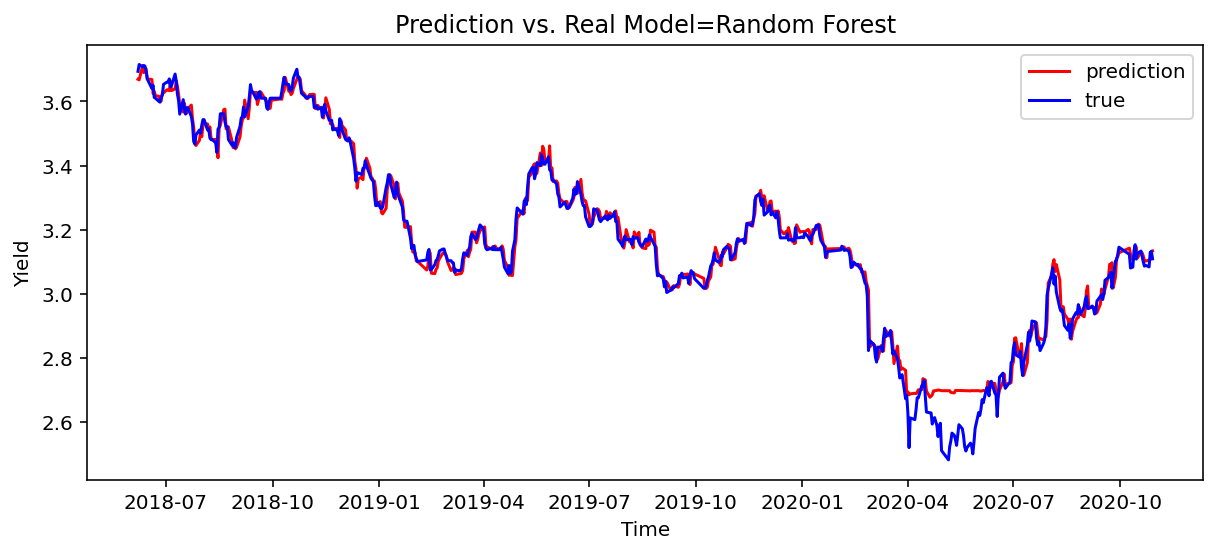

In [40]:
plt.figure(figsize=(10,4))
plt.plot(date, y_predict_tree, color='red', label="prediction")
plt.plot(date, y_test, color='blue', label='true')
plt.title('Prediction vs. Real Model=Random Forest')
plt.xlabel('Time')
plt.ylabel('Yield')
plt.legend();

In [41]:
from scipy import stats
stats.ttest_ind(y_predict_tree, y_test)

Ttest_indResult(statistic=0.638276388460375, pvalue=0.5234159717733742)

In [42]:
MSE(y_predict_tree, y_test)

0.001813878960738628

**Average Model**

In [43]:
start=time.time()
y_average=[]
for i in range(0, len(y_predict_tree)):
  y_average.append((y_predict_svr[i]+y_predict_tree[i])/2)
print('Training time cost {:.2f} s'.format(time.time()-start))

Training time cost 0.00 s


In [44]:
stats.ttest_ind(y_average, y_test)

Ttest_indResult(statistic=1.955442317683715, pvalue=0.05076347837087776)

In [ ]:
MSE(y_average, y_test)

0.004290457129214603

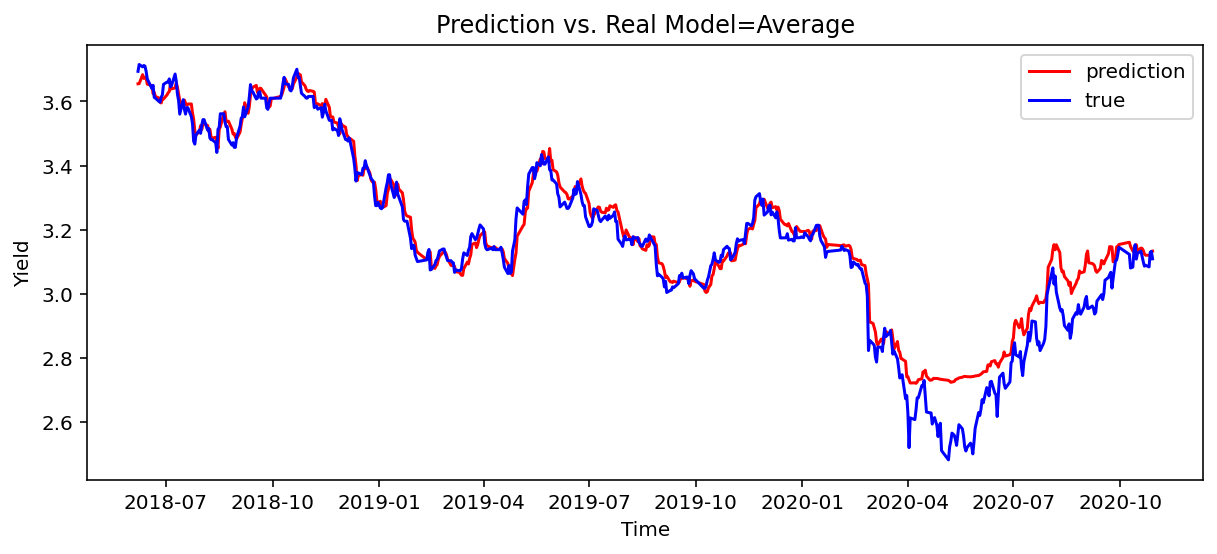

In [45]:
plt.figure(figsize=(10,4))
plt.plot(date, y_average, color='red', label="prediction")
plt.plot(date, y_test, color='blue', label='true')
plt.title('Prediction vs. Real Model=Average')
plt.xlabel('Time')
plt.ylabel('Yield')
plt.legend();

Base Model: ARIMA https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/

 Parameter Analysis for the ARIMA model

In [46]:
pip install pmdarima 

     |████████████████████████████████| 1.5MB 12.5MB/s 
     |████████████████████████████████| 9.5MB 47.8MB/s 
     |████████████████████████████████| 2.1MB 47.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


**Understanding the pattern**


In [47]:
# Import the library 
from pmdarima import auto_arima 
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(x=df['Yield of 10-year Treasury Bond'], model='additive', extrapolate_trend='freq', period=10)

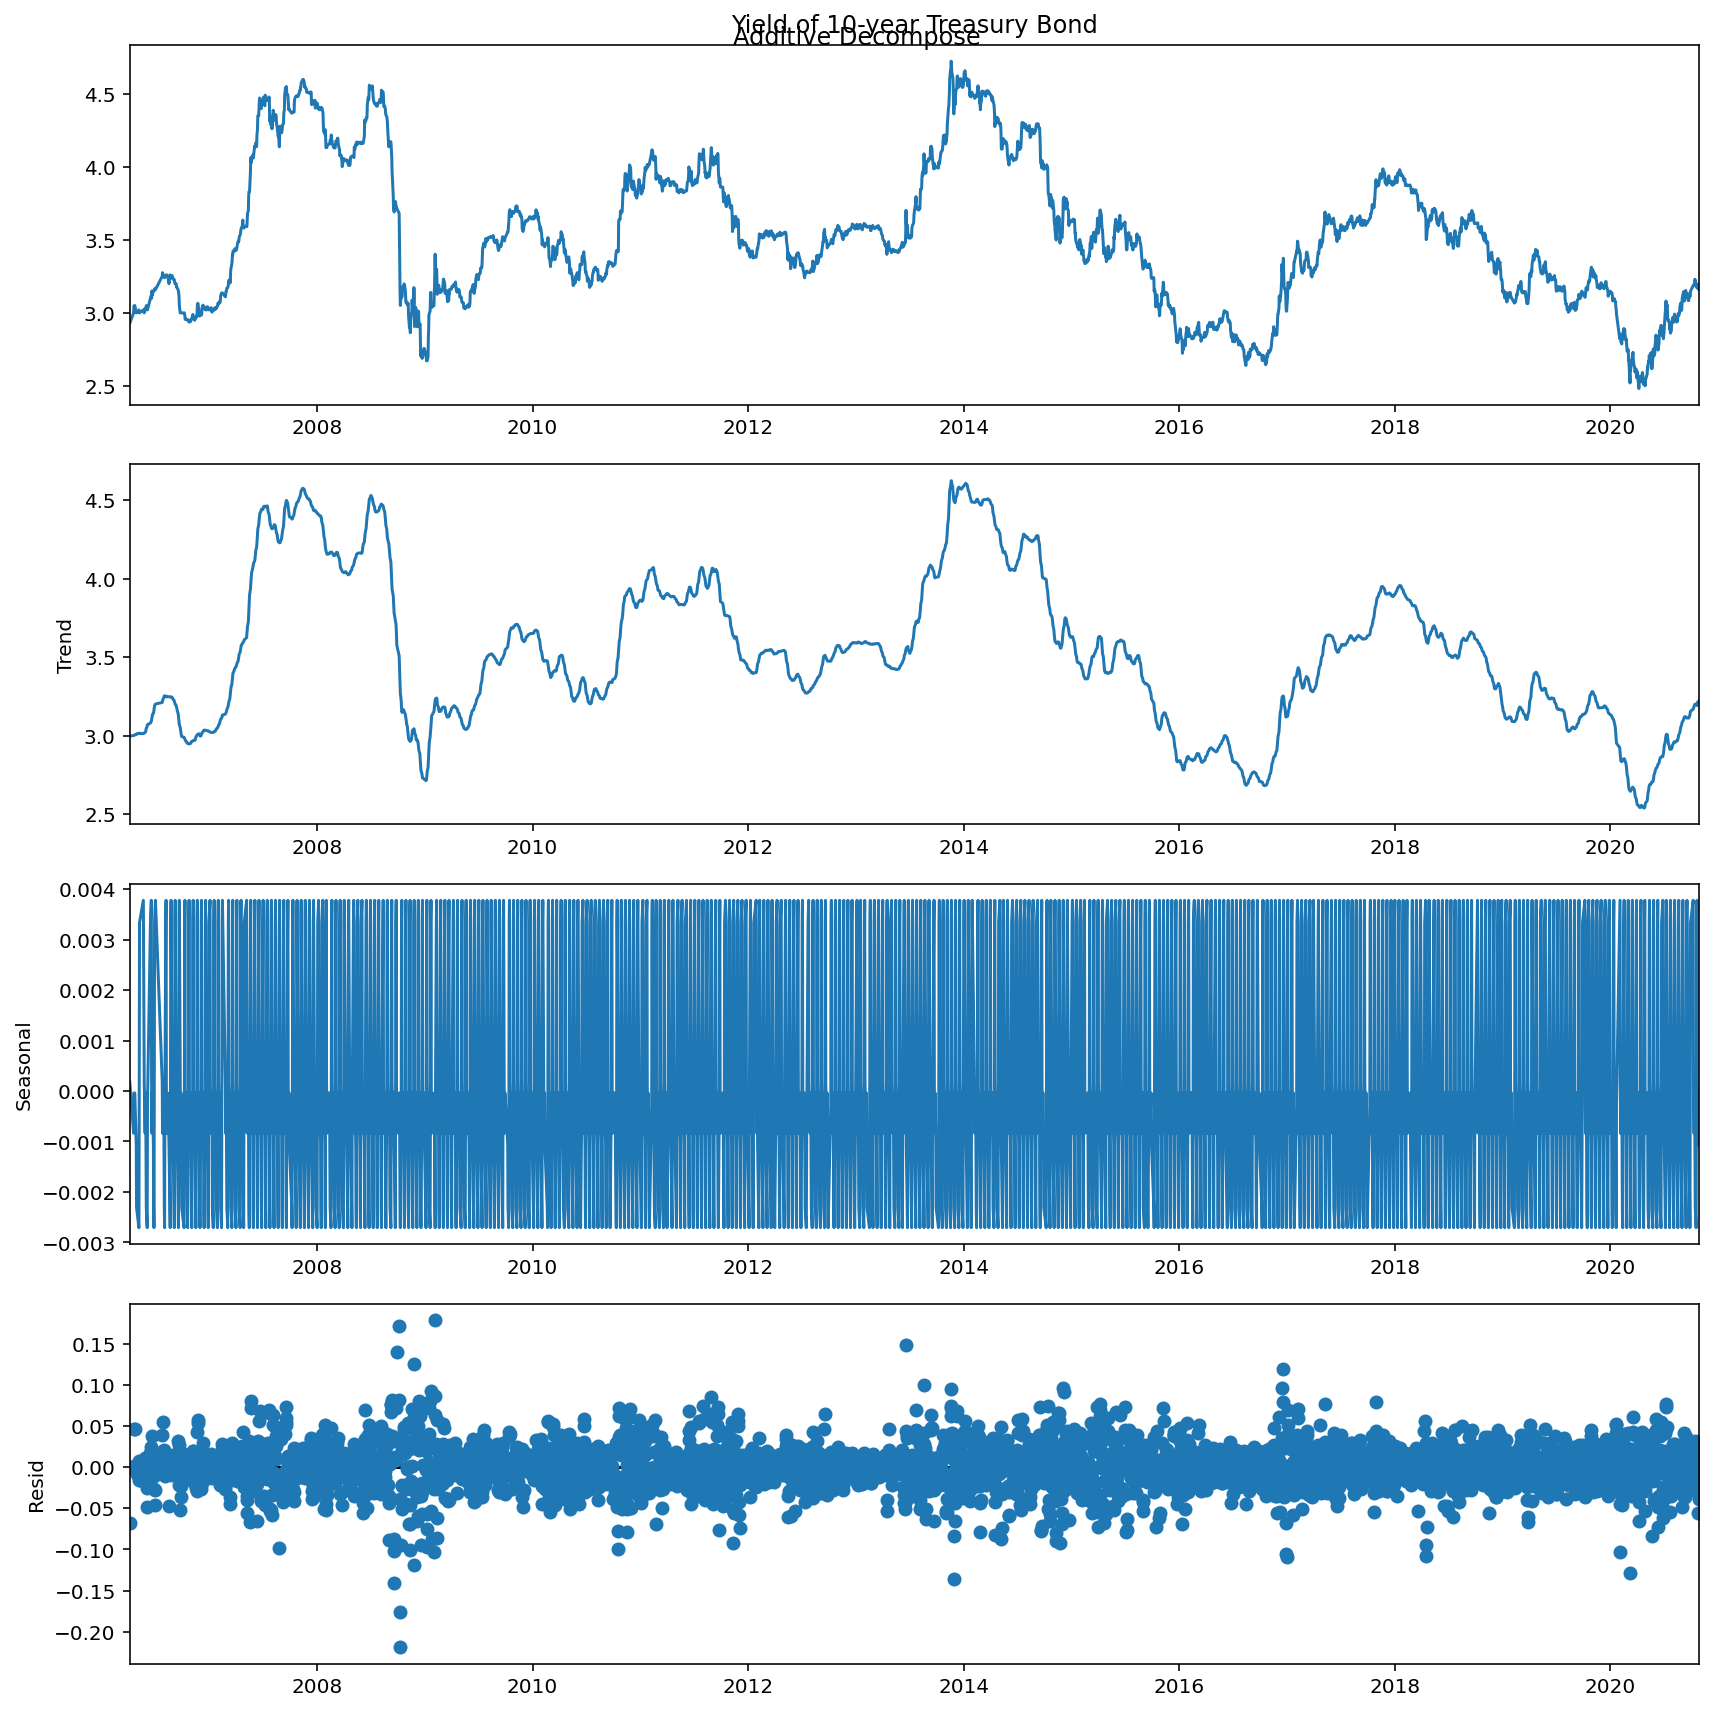

<Figure size 864x864 with 0 Axes>

In [51]:
plt.rcParams.update({'figure.figsize': (12,12)})
result_add.plot().suptitle('Additive Decompose', fontsize=12)
plt.show()
plt.savefig('books_read.png')

**Test for Stationarity**

Stationarity is an important concept in time-series and any time-series data should undergo a stationarity test before proceeding with a model.

We use the ‘Augmented Dickey-Fuller Test’ to check whether the data is stationary or not which is available in the ‘pmdarima’ package.

In [53]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data['Yield of 10-year Treasury Bond'])

(0.1461391678537689, True)

In [54]:
adf_test.is_stationary(data['Yield of 10-year Treasury Bond'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  """Entry point for launching an IPython kernel.


(0.1461391678537689, True)

The data is stationary.

**Parameter Analysis for the ARIMA model**

This block takes forever and did not give results because ARIMA is not a good choice for this dataset.

In [57]:
# Import the library 
from pmdarima import auto_arima 
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(df['Yield of 10-year Treasury Bond'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=32.97 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-4991.758, Time=1.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-14029.315, Time=16.38 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-8822.560, Time=11.14 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-4993.661, Time=0.33 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-13018.380, Time=3.29 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-14477.278, Time=50.83 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=72.96 sec


KeyboardInterrupt: ignored